In [1]:
import csv
import math
import matplotlib.pyplot as plt 
from svmutil import *
from operator import itemgetter

In [2]:
data_set_file_path = "data/spambase.data.shuffled.txt"

converted_data_set_file_path = "data/spambase.data.shuffled.converted.txt"

learn_scaled_converted_data_set_file_path = "data/spambase.data.shuffled.converted.learn.scaled.txt"
test_scaled_converted_data_set_file_path = "data/spambase.data.shuffled.converted.test.scaled.txt"

kernel_type = 2

In [3]:
def learn_k_fold(x, y, folds_count, d_values, C_values):
    assert len(x) == len(y)
    
    results = list()
    fold_size = len(x) // folds_count
    for d in d_values:
        for C in C_values:
            params_string = '-q -t {2} -d {0} -c {1}'.format(d, C, kernel_type)
            
            accuracies = list()
            errors = list()
            for fold in range(folds_count):
                validate_sample_x = x[fold * fold_size : (fold + 1) * fold_size]
                validate_sample_y = y[fold * fold_size : (fold + 1) * fold_size]

                learn_sample_x = x[0 : fold * fold_size] + x[(fold + 1) * fold_size:]
                learn_sample_y = y[0 : fold * fold_size] + y[(fold + 1) * fold_size:]
                
                assert len(validate_sample_x) + len(learn_sample_x) == len(x)
                assert len(validate_sample_y) + len(learn_sample_y) == len(y)
                
                assert len(validate_sample_x) == fold_size
                assert len(validate_sample_y) == fold_size
                
                m = svm_train(learn_sample_y, learn_sample_x, params_string)
                p_label, p_acc, p_val = svm_predict(validate_sample_y, validate_sample_x, m, '-q')
                
                accuracies.append(p_acc[0])
                errors.append(p_acc[1] * 100) # error returned not in percents
                
            
            print("Parameters: ", params_string)
            # Calculate average error
            average_accuracy = sum(accuracies) / folds_count
            print("Cross Validation Accuracy = ", average_accuracy)
            average_error = sum(errors) / folds_count
            print("Cross Validation Error = ", average_error)
            sd = math.sqrt(sum([(average_error - error)**2 for error in errors]) / folds_count)
            print("Standard Deviation = ", sd)
            
            
            # Calculate empirical risk
            m = svm_train(y, x, params_string)
            p_label, p_acc, p_val = svm_predict(y, x, m, '-q')
            empirical_risk = p_acc[1] * 100
            print("Empirical risk = ", empirical_risk)
            
            
            results.append((d, C, average_accuracy, average_error, sd, empirical_risk))
    
    return results

In [4]:
k = 20

d_values = [1]
C_values = [2**x for x in range(-k, k + 1)]

y, x = svm_read_problem(learn_scaled_converted_data_set_file_path)

k_fold_results = learn_k_fold(x, y, 10, d_values, C_values)

Parameters:  -q -t 2 -d 1 -c 9.5367431640625e-07
Cross Validation Accuracy =  60.72463768115942
Cross Validation Error =  39.27536231884058
Standard Deviation =  2.6127183155536153
Empirical risk =  39.27536231884058
Parameters:  -q -t 2 -d 1 -c 1.9073486328125e-06
Cross Validation Accuracy =  60.72463768115942
Cross Validation Error =  39.27536231884058
Standard Deviation =  2.6127183155536153
Empirical risk =  39.27536231884058
Parameters:  -q -t 2 -d 1 -c 3.814697265625e-06
Cross Validation Accuracy =  60.72463768115942
Cross Validation Error =  39.27536231884058
Standard Deviation =  2.6127183155536153
Empirical risk =  39.27536231884058
Parameters:  -q -t 2 -d 1 -c 7.62939453125e-06
Cross Validation Accuracy =  60.72463768115942
Cross Validation Error =  39.27536231884058
Standard Deviation =  2.6127183155536153
Empirical risk =  39.27536231884058
Parameters:  -q -t 2 -d 1 -c 1.52587890625e-05
Cross Validation Accuracy =  60.72463768115942
Cross Validation Error =  39.275362318840

Parameters:  -q -t 2 -d 1 -c 1048576
Cross Validation Accuracy =  92.20289855072463
Cross Validation Error =  7.797101449275362
Standard Deviation =  1.5197364323383573
Empirical risk =  1.5072463768115942


d =  1


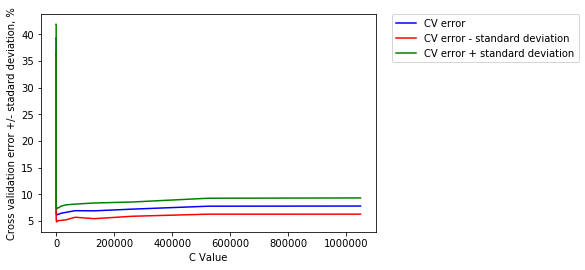

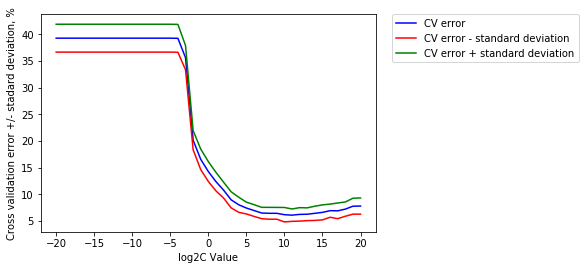

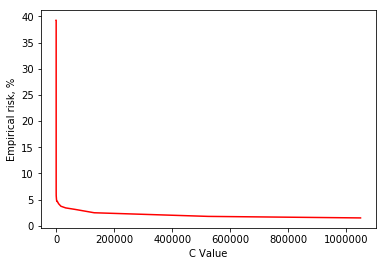

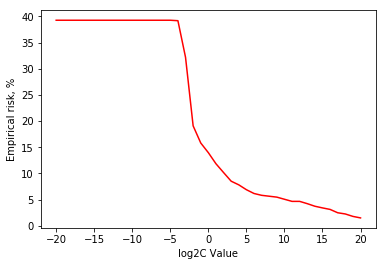

In [5]:
for d_value in d_values:
    d_results = [(d, C, average_accuracy, average_error, sd, empirical_risk) for d, C, average_accuracy, average_error, sd, empirical_risk in k_fold_results if d == d_value]
    k_values = [math.log(d_result[1], 2) for d_result in d_results]
    error_values = [d_result[3] for d_result in d_results]
    error_values_with_sd = [d_result[3] + d_result[4] for d_result in d_results]
    error_values_without_sd = [d_result[3] - d_result[4] for d_result in d_results]

    print("d = ", d_value)
    plt.plot(C_values, error_values, 'b', label = "CV error")
    plt.plot(C_values, error_values_without_sd, 'r', label = "CV error - standard deviation") 
    plt.plot(C_values, error_values_with_sd, 'g', label = "CV error + standard deviation")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel("С Value")
    plt.ylabel("Сross validation error +/- stadard deviation, %")
    plt.show()
    
    plt.plot(k_values, error_values, 'b', label = "CV error")
    plt.plot(k_values, error_values_without_sd, 'r', label = "CV error - standard deviation") 
    plt.plot(k_values, error_values_with_sd, 'g', label = "CV error + standard deviation")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel("log2C Value")
    plt.ylabel("Сross validation error +/- stadard deviation, %")
    plt.show()
    
    risks = [d_result[5] for d_result in d_results]
    
    plt.plot(C_values, risks, 'r')
    plt.xlabel("С Value")
    plt.ylabel("Empirical risk, %")
    plt.show()
    
    plt.plot(k_values, risks, 'r')
    plt.xlabel("log2C Value")
    plt.ylabel("Empirical risk, %")
    plt.show()